## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

### Goals:
#### Use Scikit-Learn pipelines to define special features to add to a Naive Bayes Classifier
#### Evaluate the accuracy of the classifier
#### Maybe do it live, on a Twitter API stream

### Methods:
#### Use the training set I made before

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from textblob import TextBlob
from time import sleep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import tweepy
import nltk
import re

#### Load the CSV

In [3]:
df = pd.read_csv("../data/training_data/Subtweets_Classifier_Training_Data.csv")

#### Create training and test sets from the single training set I made before

In [4]:
text_train, text_test, class_train, class_test = train_test_split(df.alleged_subtweet.tolist(), 
                                                                  df.is_subtweet.tolist())

#### Use NLTK's tokenizer instead of Scikit's

In [5]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Class for distinguishing polarizing parts of speech as features

In [6]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        first_names = ["Aaliyah", "Aaron", "Abby", "Abigail", "Abraham", "Adam",
                       "Addison", "Adrian", "Adriana", "Adrianna", "Aidan", "Aiden",
                       "Alan", "Alana", "Alejandro", "Alex", "Alexa", "Alexander",
                       "Alexandra", "Alexandria", "Alexia", "Alexis", "Alicia", "Allison",
                       "Alondra", "Alyssa", "Amanda", "Amber", "Amelia", "Amy",
                       "Ana", "Andrea", "Andres", "Andrew", "Angel", "Angela",
                       "Angelica", "Angelina", "Anna", "Anthony", "Antonio", "Ariana",
                       "Arianna", "Ashley", "Ashlyn", "Ashton", "Aubrey", "Audrey",
                       "Austin", "Autumn", "Ava", "Avery", "Ayden", "Bailey",
                       "Benjamin", "Bianca", "Blake", "Braden", "Bradley", "Brady",
                       "Brandon", "Brayden", "Breanna", "Brendan", "Brian", "Briana",
                       "Brianna", "Brittany", "Brody", "Brooke", "Brooklyn", "Bryan",
                       "Bryce", "Bryson", "Caden", "Caitlin", "Caitlyn", "Caleb",
                       "Cameron", "Camila", "Carlos", "Caroline", "Carson", "Carter",
                       "Cassandra", "Cassidy", "Catherine", "Cesar", "Charles", "Charlotte",
                       "Chase", "Chelsea", "Cheyenne", "Chloe", "Christian", "Christina",
                       "Christopher", "Claire", "Cody", "Colby", "Cole", "Colin",
                       "Collin", "Colton", "Conner", "Connor", "Cooper", "Courtney",
                       "Cristian", "Crystal", "Daisy", "Dakota", "Dalton", "Damian",
                       "Daniel", "Daniela", "Danielle", "David", "Delaney", "Derek",
                       "Destiny", "Devin", "Devon", "Diana", "Diego", "Dominic",
                       "Donovan", "Dylan", "Edgar", "Eduardo", "Edward", "Edwin",
                       "Eli", "Elias", "Elijah", "Elizabeth", "Ella", "Ellie", 
                       "Emily", "Emma", "Emmanuel", "Eric", "Erica", "Erick",
                       "Erik", "Erin", "Ethan", "Eva", "Evan", "Evelyn",
                       "Faith", "Fernando", "Francisco", "Gabriel", "Gabriela", "Gabriella",
                       "Gabrielle", "Gage", "Garrett", "Gavin", "Genesis", "George",
                       "Gianna", "Giovanni", "Giselle", "Grace", "Gracie", "Grant",
                       "Gregory", "Hailey", "Haley", "Hannah", "Hayden", "Hector",
                       "Henry", "Hope", "Hunter", "Ian", "Isaac", "Isabel",
                       "Isabella", "Isabelle", "Isaiah", "Ivan", "Jack", "Jackson",
                       "Jacob", "Jacqueline", "Jada", "Jade", "Jaden", "Jake",
                       "Jalen", "James", "Jared", "Jasmin", "Jasmine", "Jason", 
                       "Javier", "Jayden", "Jayla", "Jazmin", "Jeffrey", "Jenna",
                       "Jennifer", "Jeremiah", "Jeremy", "Jesse", "Jessica", "Jesus",
                       "Jillian", "Jocelyn", "Joel", "John", "Johnathan", "Jonah",
                       "Jonathan", "Jordan", "Jordyn", "Jorge", "Jose", "Joseph",
                       "Joshua", "Josiah", "Juan", "Julia", "Julian", "Juliana",
                       "Justin", "Kaden", "Kaitlyn", "Kaleb", "Karen", "Karina",
                       "Kate", "Katelyn", "Katherine", "Kathryn", "Katie", "Kayla",
                       "Kaylee", "Kelly", "Kelsey", "Kendall", "Kennedy", "Kenneth",
                       "Kevin", "Kiara", "Kimberly", "Kyle", "Kylee", "Kylie",
                       "Landon", "Laura", "Lauren", "Layla", "Leah", "Leonardo",
                       "Leslie", "Levi", "Liam", "Liliana", "Lillian", "Lilly",
                       "Lily", "Lindsey", "Logan", "Lucas", "Lucy", "Luis",
                       "Luke", "Lydia", "Mackenzie", "Madeline", "Madelyn", "Madison",
                       "Makayla", "Makenzie", "Malachi", "Manuel", "Marco", "Marcus",
                       "Margaret", "Maria", "Mariah", "Mario", "Marissa", "Mark",
                       "Martin", "Mary", "Mason", "Matthew", "Max", "Maxwell",
                       "Maya", "Mckenzie", "Megan", "Melanie", "Melissa", "Mia",
                       "Micah", "Michael", "Michelle", "Miguel", "Mikayla", "Miranda",
                       "Molly", "Morgan", "Mya", "Naomi", "Natalia", "Natalie",
                       "Nathan", "Nathaniel", "Nevaeh", "Nicholas", "Nicolas", "Nicole",
                       "Noah", "Nolan", "Oliver", "Olivia", "Omar", "Oscar",
                       "Owen", "Paige", "Parker", "Patrick", "Paul", "Payton",
                       "Peter", "Peyton", "Preston", "Rachel", "Raymond", "Reagan",
                       "Rebecca", "Ricardo", "Richard", "Riley", "Robert", "Ruby",
                       "Ryan", "Rylee", "Sabrina", "Sadie", "Samantha", "Samuel",
                       "Sara", "Sarah", "Savannah", "Sean", "Sebastian", "Serenity",
                       "Sergio", "Seth", "Shane", "Shawn", "Shelby", "Sierra",
                       "Skylar", "Sofia", "Sophia", "Sophie", "Spencer", "Stephanie",
                       "Stephen", "Steven", "Summer", "Sydney", "Tanner", "Taylor", 
                       "Thomas", "Tiffany", "Timothy", "Travis", "Trenton", "Trevor",
                       "Trinity", "Tristan", "Tyler", "Valeria", "Valerie", "Vanessa",
                       "Veronica", "Victor", "Victoria", "Vincent", "Wesley", "William",
                       "Wyatt", "Xavier", "Zachary", "Zoe", "Zoey"]
        first_names_lower = set([name.lower() for name in first_names])

        pronouns = ["You", "You're", "Your", 
                    "She", "She's", "Her", "Hers", 
                    "He", "He's", "Him", "His", 
                    "They", "They're", "Them", "Their", "Theirs"]
        prounouns_lower = set([pronoun.lower() for pronoun in pronouns])

        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
        
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            weighted_dict = {"length": len(text), 
                             "good": len(prounouns_lower.intersection(tokenized_text)), 
                             "bad": (len(first_names_lower.intersection(tokenized_text)) 
                                     + text.count("@") 
                                     + text.count("subtweet") 
                                     + text.count("Subtweet") 
                                     + len(re.findall(pattern, text)))}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [7]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", Pipeline([
            ("counts", CountVectorizer(tokenizer=tokenizer.tokenize)),
            ("tf_idf", TfidfTransformer())
        ])),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer()),
        ])),
    ])),
    ("classifier", MultinomialNB())
])

#### Show the results

In [8]:
sentiment_pipeline.fit(text_train, class_train)
predictions = sentiment_pipeline.predict(text_test)

In [9]:
print(classification_report(class_test, predictions))

             precision    recall  f1-score   support

   negative       0.93      0.88      0.90      1812
   positive       0.89      0.93      0.91      1871

avg / total       0.91      0.90      0.90      3683



#### Define function for visualizing confusion matrices

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Show the matrices

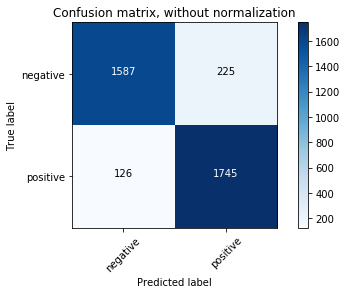

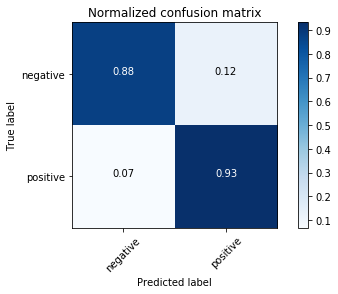

In [11]:
class_names = ["negative", "positive"]

cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Save the classifier for another time

In [12]:
joblib.dump(sentiment_pipeline, "../data/non_subtweets_data/subtweets_classifier.pkl") 

['../data/non_subtweets_data/subtweets_classifier.pkl']

#### Print tests for the classifier

In [13]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [14]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [15]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [16]:
tests_dataframe(test_tweets_df, text_column="Tweet", sentiment_column="Sentiment").head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1,None,0.055722,0.944278,Isn't it funny how some people don't know thei...
2,None,0.057134,0.942866,How come you people act like this?
0,None,0.064995,0.935005,Some people don't know their place.
3,None,0.414349,0.585651,You're such a nerd.
7,None,0.677703,0.322297,This is a subtweet.


#### Test on actual tweets

In [17]:
naji_df = pd.read_csv("../data/non_subtweets_data/naji_data.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


#### Repair some leftover HTML

In [18]:
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&quot;", "\"")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&amp;", "&")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&gt;", ">")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&lt;", "<")

#### Remove rows with non-English

In [19]:
def is_english(s):
    return all(ord(char) < 128 for char in s)

In [20]:
naji_df = naji_df[naji_df["SentimentText"].map(is_english)]

#### Show the length of the dataset

In [21]:
len(naji_df)

1564156

#### Use randomly selected 250K rows from dataset

In [22]:
naji_df = naji_df.sample(n=250000).reset_index(drop=True)

#### Print and time the tests

In [23]:
%%time
naji_df = tests_dataframe(naji_df)

CPU times: user 53.4 s, sys: 1.18 s, total: 54.6 s
Wall time: 1min 4s


In [24]:
naji_df.to_csv("../data/non_subtweets_data/naji_tests.csv")

In [25]:
naji_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
223087,0,0.008835,0.991165,I hate when boys whine bc you don't text them ...
197722,0,0.010437,0.989563,Why To People Hate Someone They Dont Know? I C...
12500,1,0.012221,0.987779,Why do most men put their hand in their trouse...
84504,0,0.012626,0.987374,I hate it when you like a guy and they have a ...
165007,0,0.013526,0.986474,Don't you just hate it when you find out that ...


#### Tests on friends' tweets

In [26]:
aaron_df = pd.read_csv("../data/friends_tweets/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

In [27]:
%%time
aaron_df = tests_dataframe(aaron_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 771 ms, sys: 21.7 ms, total: 793 ms
Wall time: 1 s


In [28]:
aaron_df.to_csv("../data/friends_tweets/akrapf96_tests.csv")

In [29]:
aaron_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
2893,None,0.011867,0.988133,I love arguing with conservative bigots who do...
225,None,0.017103,0.982897,Can people stop putting eggs in their dog's mo...
3221,None,0.019852,0.980148,I still don't understand why my brother feels ...
1756,None,0.020494,0.979506,fuck you and your anime
3236,None,0.020511,0.979489,What will straight cis people do now with thei...


In [30]:
julia_df = pd.read_csv("../data/friends_tweets/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

In [31]:
%%time
julia_df = tests_dataframe(julia_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 1.84 s, sys: 35.7 ms, total: 1.87 s
Wall time: 2.34 s


In [32]:
julia_df.to_csv("../data/friends_tweets/juliaeberry_tests.csv")

In [33]:
julia_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
773,None,0.005416,0.994584,"""I do feel grateful for the fact that we have ..."
1138,None,0.006586,0.993414,"""what a COINcidence that you're here,"" drawls ..."
3375,None,0.009707,0.990293,"""let me ask u this, who is the number one enem..."
902,None,0.010070,0.989930,tbh if they don't start publically dating in a...
663,None,0.010464,0.989536,even if you are committed to cheating how can ...


In [34]:
zoe_df = pd.read_csv("../data/friends_tweets/zoeterhune_tweets.csv").dropna()
zoe_df["Sentiment"] = None

In [35]:
%%time
zoe_df = tests_dataframe(zoe_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 253 ms, sys: 4.61 ms, total: 257 ms
Wall time: 271 ms


In [36]:
zoe_df.to_csv("../data/friends_tweets/zoeterhune_tests.csv")

In [37]:
zoe_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1304,None,0.003125,0.996875,maybe girls don’t “go for nice guys” bc they’r...
277,None,0.006470,0.993530,ok so people from my old school keep lamenting...
318,None,0.007391,0.992609,bc she’s pURDY
1186,None,0.007458,0.992542,no offense but what kind of school doesn’t let...
1195,None,0.008673,0.991327,when men get upset over women saying “when men...


In [38]:
noah_df = pd.read_csv("../data/friends_tweets/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

In [39]:
%%time
noah_df = tests_dataframe(noah_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 822 ms, sys: 13.3 ms, total: 836 ms
Wall time: 876 ms


In [40]:
noah_df.to_csv("../data/friends_tweets/noahsegalgould_tests.csv")

In [41]:
noah_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
877,None,0.000505,0.999495,I guess I think it’s foolish to rely on any we...
607,None,0.001313,0.998687,I don’t fuck with the symmetrarians
105,None,0.001888,0.998112,"In a target parking lot, I see him: he’s carry..."
608,None,0.002113,0.997887,If your face is symmetrical I don’t like you
1503,None,0.003446,0.996554,Honestly I don’t remember


#### Test it in realtime
#### Define some useful variables for later

In [42]:
THRESHOLD = 0.5
COLUMNS = ["tweet", "screen_name", "time", 
           "subtweet_probability", 
           "sentiment_polarity", 
           "sentiment_objectivity"]
DURATION = 600 # seconds

#### Load Twitter API credentials

In [43]:
consumer_key, consumer_secret, access_token, access_token_secret = open("credentials.txt").read().split("\n")

#### Prepare the final dataframe

In [44]:
subtweets_df = pd.DataFrame(columns=COLUMNS)

#### Create a custom class for streaming subtweets

In [45]:
class StreamListener(tweepy.StreamListener):
    def on_status(self, status):
        text = status.text
        #negative_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][0]
        positive_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][1]
        if positive_probability >= THRESHOLD:
            sentiment = TextBlob(text).sentiment
            row = [text, 
                   status.user.screen_name, 
                   status.created_at, 
                   positive_probability, 
                   sentiment.polarity, 
                   sentiment.objectivity]
            pd.Series(row) # Show that row
            subtweets_df.append(pd.DataFrame(row, columns=COLUMNS))
            return row

#### Use the API credentials to connect to the API

In [46]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

#### Create a list of all my followers' account IDs

In [47]:
my_followers_int = list(set(list(tweepy.Cursor(api.followers_ids, screen_name="NoahSegalGould").pages())[0]))
my_followers_str = [str(i) for i in my_followers_int]

#### Instantiate the listener

In [48]:
stream_listener = StreamListener()
stream = tweepy.Stream(auth=api.auth, listener=stream_listener)

#### Start the stream asynchronously, and stop it after some duration of seconds

In [49]:
%%time
stream.filter(follow=my_followers_str, async=True)
print("Streaming!")
sleep(DURATION)
stream.disconnect()

Streaming!
CPU times: user 51.4 ms, sys: 32.6 ms, total: 84 ms
Wall time: 10min


#### Save the dataframe

In [50]:
subtweets_df.to_csv("../data/non_subtweets_data/live_data.csv")

#### Show the dataframe

In [51]:
subtweets_df

,tweet,screen_name,time,subtweet_probability,sentiment_polarity,sentiment_objectivity
